In [ ]:
pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [ ]:
import pandas
import numpy as np

In [ ]:
import os

# List the contents of the dataset directory
print(os.listdir(path))

['asl_alphabet_test', 'asl_alphabet_train']


In [ ]:
import tensorflow as tf
import os

# Define the paths to the training and testing image directories
train_dir = os.path.join(path, 'asl_alphabet_train', 'asl_alphabet_train')
test_dir = os.path.join(path, 'asl_alphabet_test', 'asl_alphabet_test')

# Set image size and batch size
IMG_HEIGHT = 50
IMG_WIDTH = 50
BATCH_SIZE = 32

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=429 # for reproducibility
)

# --- Fix for the test dataset ---
# The test directory 'asl_alphabet_test/asl_alphabet_test' contains images directly
# (e.g., 'A_test.jpg'), not in subdirectories per class as expected by labels='inferred'.
# We need to manually construct the test dataset.

test_image_paths = []
test_labels = []

# Get the class names from the training dataset for consistent mapping
class_names = train_ds.class_names
class_name_to_label_id = {name: i for i, name in enumerate(class_names)}

for filename in os.listdir(test_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        image_path = os.path.join(test_dir, filename)
        # Extract label from filename (e.g., 'A_test.jpg' -> 'A')
        label_name = filename.split('_')[0]
        if label_name in class_name_to_label_id:
            test_image_paths.append(image_path)
            test_labels.append(class_name_to_label_id[label_name])
        else:
            # Handle cases where a test label might not be in training class names if necessary
            # For this dataset, it's expected to be consistent.
            print(f"Warning: Label '{label_name}' from '{filename}' not found in training class names. Skipping.")

# Convert to TensorFlow tensors
test_image_paths_tensor = tf.constant(test_image_paths)
test_labels_tensor = tf.constant(test_labels, dtype=tf.int32)

# Function to decode and preprocess images
def decode_img(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    # Use tf.image.decode_jpeg for .jpg files for more robustness
    img = tf.image.decode_jpeg(img, channels=3) # Decode to 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize to [0,1]
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def process_path(file_path, label):
    img = decode_img(file_path, IMG_HEIGHT, IMG_WIDTH)
    return img, label

# Create the test dataset from tensors and apply preprocessing
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths_tensor, test_labels_tensor))
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n--- Training Dataset Info ---")
print(f"Number of batches in training dataset: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Class names: {train_ds.class_names}")

print("\n--- Testing Dataset Info ---")
print(f"Number of batches in testing dataset: {tf.data.experimental.cardinality(test_ds).numpy()}")
# For the manually constructed test_ds, class_names are derived from the training set.
print(f"Class names (inferred from training): {class_names}")

Found 87000 files belonging to 29 classes.

--- Training Dataset Info ---
Number of batches in training dataset: 2719
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

--- Testing Dataset Info ---
Number of batches in testing dataset: 1
Class names (inferred from training): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Manually collect all image paths and their corresponding labels from the training directory
image_paths = []
image_labels = []

# Get class names from the existing train_ds for consistent mapping
class_names = train_ds.class_names
class_name_to_label_id = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        label_id = class_name_to_label_id[class_name]
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_paths.append(os.path.join(class_path, filename))
                image_labels.append(label_id)

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

print(f"Total images found in train_dir: {len(image_paths)}")

# Perform the stratified split on indices
train_indices, val_indices = train_test_split(
    np.arange(len(image_paths)),
    test_size=0.2,
    stratify=image_labels,
    random_state=429
)

# Get the stratified image paths and labels
stratified_train_paths = image_paths[train_indices]
stratified_train_labels = image_labels[train_indices]

stratified_val_paths = image_paths[val_indices]
stratified_val_labels = image_labels[val_indices]

# Create the stratified training dataset
stratified_train_ds = tf.data.Dataset.from_tensor_slices((stratified_train_paths, stratified_train_labels))
stratified_train_ds = stratified_train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
stratified_train_ds = stratified_train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the stratified validation dataset
stratified_val_ds = tf.data.Dataset.from_tensor_slices((stratified_val_paths, stratified_val_labels))
stratified_val_ds = stratified_val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
stratified_val_ds = stratified_val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n--- Stratified Dataset Info ---")
print(f"Number of images in stratified training dataset: {len(stratified_train_paths)}")
print(f"Number of images in stratified validation dataset: {len(stratified_val_paths)}")
print(f"Number of batches in stratified training dataset: {tf.data.experimental.cardinality(stratified_train_ds).numpy()}")
print(f"Number of batches in stratified validation dataset: {tf.data.experimental.cardinality(stratified_val_ds).numpy()}")
print(f"Class names: {class_names}")

Total images found in train_dir: 87000

--- Stratified Dataset Info ---
Number of images in stratified training dataset: 69600
Number of images in stratified validation dataset: 17400
Number of batches in stratified training dataset: 2175
Number of batches in stratified validation dataset: 544
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


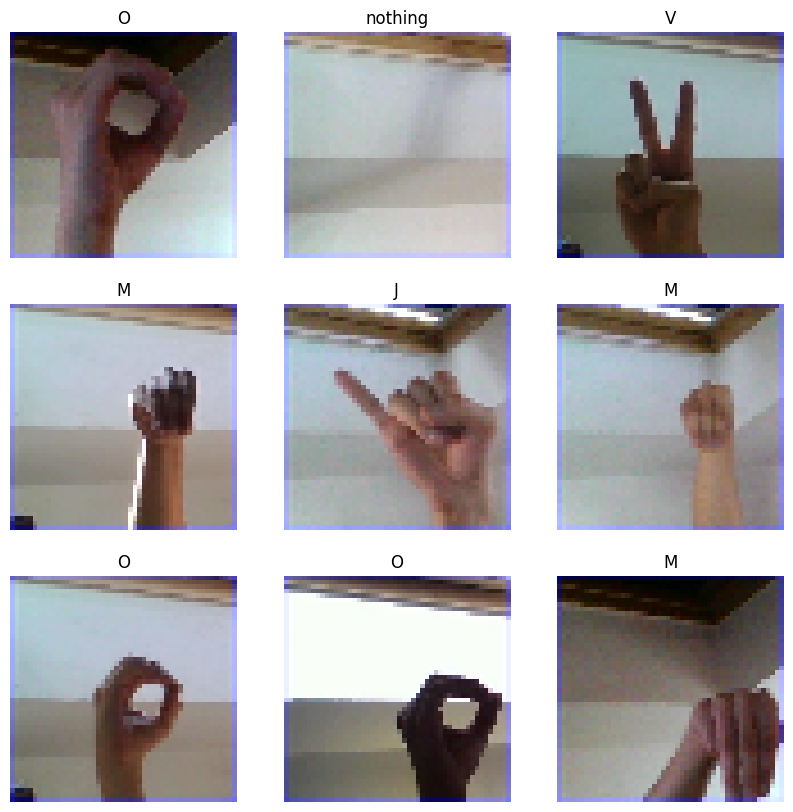

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

# Custom CNN

In [ ]:
from keras.activations import relu,softmax , sigmoid , tanh,swish
from keras.layers import Dense , Input , Flatten , RandomBrightness , Dropout , ReLU,Normalization , BatchNormalization, MaxPool2D,Conv2D, GlobalAveragePooling2D, ELU, LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam , SGD , RMSprop
from keras.optimizers.schedules import ExponentialDecay , PolynomialDecay , PiecewiseConstantDecay , CosineDecay, CosineDecayRestarts,InverseTimeDecay
from keras.models import Sequential , Model
from keras.src.legacy.preprocessing.image import ImageDataGenerator


In [ ]:
print(train_dir)
print(test_dir)
print(val_indices)

/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test
[75606  9002 64723 ... 15826 11738 60721]


In [ ]:
import pandas as pd

train_data_generator = ImageDataGenerator(rescale=1./255)
val_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_data_directory_iterator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create a DataFrame for stratified validation data to use with flow_from_dataframe
# We need to convert numerical labels back to class names for 'categorical' class_mode
val_df = pd.DataFrame({
    'filepaths': stratified_val_paths,
    'labels': [class_names[label] for label in stratified_val_labels]
})

val_data_director_iterator = val_data_generator.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Changed from (100, 100) to (IMG_HEIGHT, IMG_WIDTH) for consistency
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Typically, shuffle is false for validation/test sets
)

# The test directory 'asl_alphabet_test/asl_alphabet_test' contains images directly (e.g., 'A_test.jpg'),
# not in subdirectories per class as expected by flow_from_directory with class_mode='categorical'.
# Instead, we will use the test_ds created earlier which is a tf.data.Dataset for consistency
# and because it correctly handles the structure of the test directory.
# For now, I will comment out the problematic test_data_directory_iterator.
# If a Keras ImageDataGenerator-based test iterator is strictly needed, a similar
# flow_from_dataframe approach would be required after parsing the test directory structure.
# test_data_directory_iterator = test_data_generator.flow_from_directory(
#     test_dir,
#     target_size=(100, 100),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

print(train_data_generator)
print(val_data_director_iterator)

Found 87000 images belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [ ]:
batch, labels = train_data_directory_iterator[0]
print(batch.shape)
print(labels.shape)

(32, 50, 50, 3)
(32, 29)


## Model Architecture

In [ ]:
model = Sequential([
     # First Layer
     Conv2D(36, kernel_size=(5,5), padding='valid', strides=(1,1), activation='relu', kernel_initializer='he_uniform', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     BatchNormalization(),
     MaxPool2D(2,2),

     # Second Layer
     Conv2D(66, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu', kernel_initializer='he_uniform'),
     BatchNormalization(),
     MaxPool2D(2,2),
     Dropout(0.2),

     # Third Layer
     Conv2D(66, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu', kernel_initializer='he_uniform'),
     BatchNormalization(),
     MaxPool2D(2,2),
     Dropout(0.2),

     Flatten(),
     Dense(712, activation='relu', kernel_initializer='he_uniform'),
     BatchNormalization(),
     Dropout(0.2),
     Dense(len(class_names), activation='softmax', kernel_initializer='glorot_uniform')
 ])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 36)     │         2,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 66)     │        21,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 21, 21, 66)     │           264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 66)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 66)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 66)       │        39,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 66)       │           264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 66)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 66)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 712)            │       752,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 712)            │         2,848 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 712)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │        20,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,237 (3.21 MB)

 Trainable params: 838,477 (3.20 MB)

 Non-trainable params: 1,760 (6.88 KB)

## Model Training

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Saves best model weights
checkpoint = ModelCheckpoint(filepath='S-A_best_model.weights.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, mode='min', verbose=1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Runtime: ~40 min

In [ ]:
history = model.fit(train_data_directory_iterator, epochs=20, validation_data=val_data_director_iterator, callbacks=[checkpoint, reduce_lr_cb])

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2718/2719 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6156 - loss: 1.3523
Epoch 1: val_accuracy improved from -inf to 0.93759, saving model to S-A_best_model.weights.h5
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 137s 47ms/step - accuracy: 0.6158 - loss: 1.3519 - val_accuracy: 0.9376 - val_loss: 0.1865 - learning_rate: 0.0010
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9455 - loss: 0.1637
Epoch 2: val_accuracy did not improve from 0.93759
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 120s 44ms/step - accuracy: 0.9455 - loss: 0.1637 - val_accuracy: 0.8878 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 3/20
2718/2719 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9662 - loss: 0.1025
Epoch 3: val_accuracy did not improve from 0.93759
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 119s 44ms/step - accuracy: 0.9662 - loss: 0.1025 - val_accuracy: 0.9112 - val_loss: 0.2954 - learning_rate: 0.0010
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9771 - loss: 0.0667
Epoch 4: val_accurac

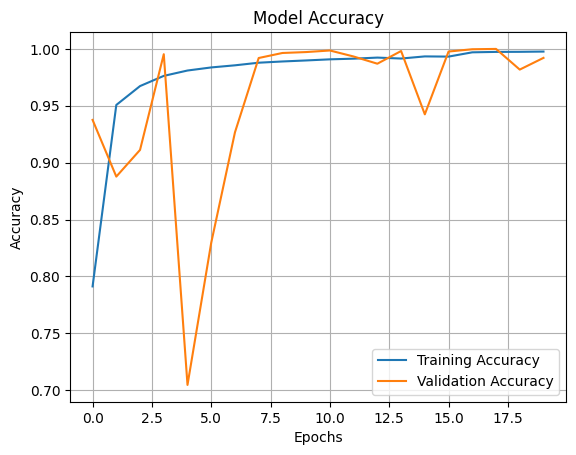

In [ ]:

plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

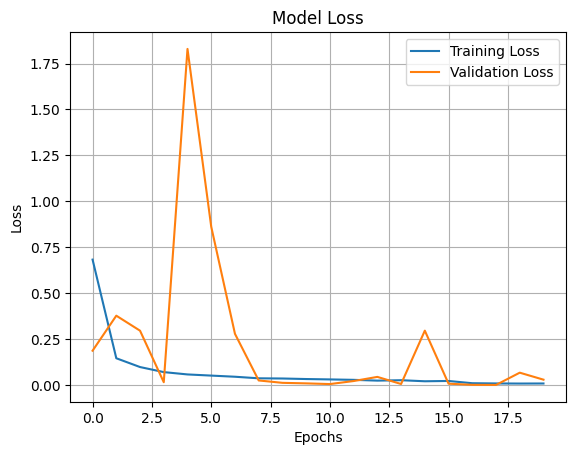

In [ ]:

plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import tensorflow as tf

# Ensure class_names is available (it was defined in previous cells)
num_classes = len(class_names)

# Create a one-hot encoded version of test_ds for model evaluation
def one_hot_encode_label_for_eval(image, label):
    return image, tf.one_hot(label, depth=num_classes)

test_ds_one_hot = test_ds.map(one_hot_encode_label_for_eval, num_parallel_calls=tf.data.AUTOTUNE)
# Re-cache and prefetch for performance, similar to how test_ds was initially set up
test_ds_one_hot = test_ds_one_hot.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Evaluate the model on the test dataset (with one-hot labels)
print("\nEvaluating model on the test dataset...")
loss, accuracy = model.evaluate(test_ds_one_hot) # Use the one-hot encoded dataset
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the classification report and confusion matrix
y_true = []
y_pred_raw = []

# Iterate over the original test_ds (which yields integer labels) for y_true
# and use model.predict on the images.
for images, labels in test_ds:
    y_true.extend(labels.numpy()) # These are the original integer labels
    y_pred_raw.extend(model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_raw = np.array(y_pred_raw)
y_pred = np.argmax(y_pred_raw, axis=1)

# Ensure class_names are consistent with the training dataset
# class_names was defined in cell a8f27ac4 and used in 6c32aa22
# For convenience, we can re-fetch it or assume it's still available.
# If class_names is not available, uncomment and run: class_names = train_ds.class_names

cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:\n")
# Fix: Pass 'labels' argument to classification_report to include all classes
# This handles cases where some classes might be missing from the test set
report = classification_report(y_true, y_pred, target_names=class_names, labels=np.arange(num_classes), output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, labels=np.arange(num_classes)))

# Extract and print F1-score
weighted_f1_score = report['weighted avg']['f1-score']
print(f"\nWeighted Average F1-score: {weighted_f1_score:.4f}")



Evaluating model on the test dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 1.0000 - loss: 1.9116e-06
Test Loss: 0.0000
Test Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [ ]:

# Fix for heatmap: Get class names only for the labels present in y_true
# as confusion_matrix will only create a matrix for the labels it finds.
unique_true_labels = sorted(np.unique(y_true))
class_labels_for_heatmap = [class_names[i] for i in unique_true_labels]

plt.figure(figsize=(12,10))
# Fix: Use class_labels_for_heatmap for xticklabels and yticklabels
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_for_heatmap, yticklabels=class_labels_for_heatmap)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('S-A Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Test Model Inference (New Test Set)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get best model
model.load_weights('/content/drive/Shareddrives/429_Project/S-A_best_model.weights.h5')
print("Best model weights loaded successfully.")

Best model weights loaded successfully.


In [ ]:
inference_images_path = '/content/drive/Shareddrives/429_Project/MYHANDS'

# Check if the directory exists and list its contents
if os.path.exists(inference_images_path):
    print(f"Contents of directory: {os.listdir(inference_images_path)}")
else:
    print(f"Error: Directory '{inference_images_path}' not found. Please ensure the path is correct.")

# It's important to know the image files contained in this directory for loading later.

Contents of directory: ['L1.jpg', 'W1.jpg', 'V1.jpg', 'X1.jpg', 'Y1.jpg', 'V2.jpg', 'W2.jpg', 'T1.jpg', 'S1.jpg', 'D1.jpg', 'E1.jpg', 'F1.jpg', 'R1.jpg', 'L2.jpg', 'C1.jpg', 'U1.jpg', 'A1.jpg', 'B1.jpg', 'I1.jpg', 'O1.jpg']


**Reasoning**:
I need to load and preprocess the inference images from the specified path using the previously defined preprocessing function, and then prepare them for prediction by the loaded model. This involves iterating through the image files, decoding and resizing them, and finally stacking them into a tensor.



In [ ]:
import tensorflow as tf

# List all image files in the inference directory
image_filenames = [f for f in os.listdir(inference_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_filepaths = [os.path.join(inference_images_path, f) for f in image_filenames]

# Prepare images for inference
inference_images = []
for img_path in image_filepaths:
    img = decode_img(img_path, IMG_HEIGHT, IMG_WIDTH)
    inference_images.append(img)

# Stack images into a single tensor and add batch dimension
inference_tensor = tf.stack(inference_images)

# Display some information about the prepared inference tensor
print(f"Number of inference images found: {len(image_filepaths)}")
print(f"Shape of inference tensor: {inference_tensor.shape}")

Number of inference images found: 20
Shape of inference tensor: (20, 50, 50, 3)


**Reasoning**:
The previous code block successfully loaded and preprocessed the inference images, stacking them into a tensor. The next logical step is to use this `inference_tensor` to get predictions from the loaded model.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
Raw predictions for the first 3 images:
[[1.08823963e-12 1.30575867e-15 5.54601720e-13 1.49430815e-13
  5.69936865e-16 4.49816158e-16 1.88294630e-17 2.46743652e-13
  4.54843700e-07 2.59577053e-08 6.12442909e-12 9.99999523e-01
  1.54309244e-14 1.22251334e-10 1.46148949e-13 1.03480717e-08
  2.11362230e-11 2.68121007e-12 4.40139766e-14 4.30732811e-10
  3.02865124e-19 6.40098860e-15 1.04881970e-20 8.46601676e-19
  8.94440005e-16 5.36347677e-08 1.52487143e-20 1.39655284e-11
  9.50426698e-19]
 [1.37099652e-12 9.93363161e-13 2.81920498e-19 9.04455640e-16
  3.92423588e-16 1.50519598e-13 2.81550580e-13 3.56908344e-14
  1.85842716e-10 4.81036377e-10 9.99999881e-01 2.86809221e-09
  1.72623711e-08 7.86175847e-10 1.39157809e-19 1.53383182e-14
  7.44965645e-21 1.44129444e-07 1.81554254e-18 1.15951895e-17
  5.24873851e-18 3.62315444e-09 1.71725689e-10 7.10204833e-17
  7.69958657e-18 3.37891234e-19 4.65768342e-20 2.06805341e-12
  1.43986128e-13]
 [8.56462290e-10 

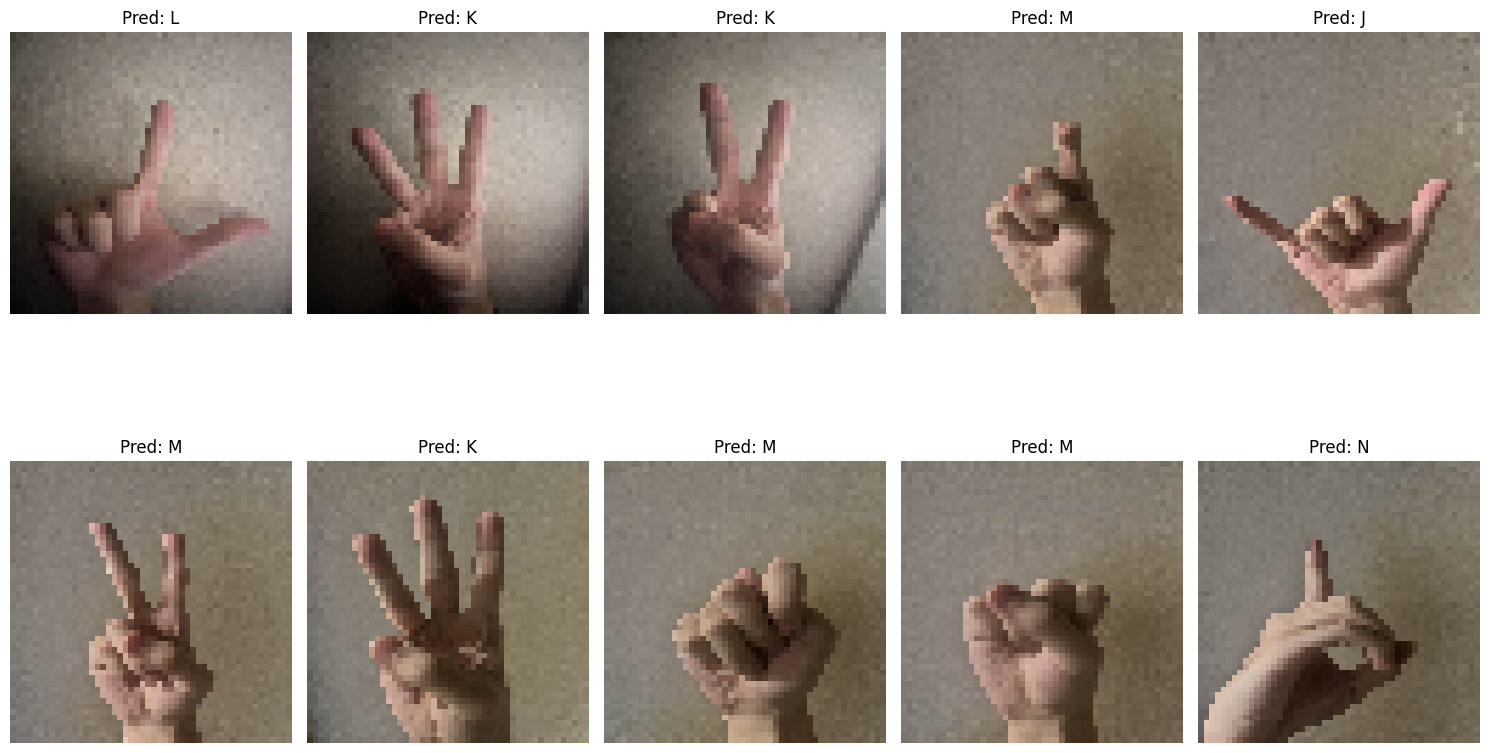

In [ ]:
predictions = model.predict(inference_tensor)

# Display the raw predictions for the first few images as an example
print("Raw predictions for the first 3 images:")
print(predictions[:3])

# Get the predicted class labels
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Map predicted class indices to class names
predicted_class_names = [class_names[idx] for idx in predicted_classes]

print(f"\nPredicted classes for the inference images: {predicted_class_names}")

# Optionally, if you want to display the image along with its prediction
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(min(len(image_filepaths), 10)): # Display up to 10 images
    ax = plt.subplot(2, 5, i + 1)
    # Convert the normalized tensor back to a displayable image format (0-255, uint8)
    display_img = (inference_images[i].numpy() * 255).astype("uint8")
    plt.imshow(display_img)
    plt.title(f"Pred: {predicted_class_names[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
ground_truth_labels = []

for filename in image_filenames:
    # Extract the first character as the class label (e.g., 'L' from 'L1.jpg')
    # Assuming the format is always 'LETTER_NUMBER.jpg' or 'LETTERNUMBER.jpg'
    # The first character is consistently the label.
    label_char = filename[0].upper() # Ensure consistency with class_names being uppercase

    if label_char in class_name_to_label_id:
        ground_truth_labels.append(class_name_to_label_id[label_char])
    else:
        print(f"Warning: Character '{label_char}' extracted from '{filename}' not found in class_name_to_label_id. Skipping.")

print(f"Extracted ground truth labels (numerical IDs): {ground_truth_labels}")

Extracted ground truth labels (numerical IDs): [11, 22, 21, 23, 24, 21, 22, 19, 18, 3, 4, 5, 17, 11, 2, 20, 0, 1, 8, 14]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate overall accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_classes)
print(f"Accuracy on Bob's Images: {accuracy:.4f}")

# Calculate weighted F1-score
f1 = f1_score(ground_truth_labels, predicted_classes, average='weighted')
print(f"Weighted F1-score on Bob's Images: {f1:.4f}")

Accuracy on Bob's Images: 0.1500
Weighted F1-score on Bob's Images: 0.1500


In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
report = classification_report(ground_truth_labels, predicted_classes, target_names=class_names, labels=np.arange(len(class_names)), output_dict=True)
print("\nClassification Report on Inference Images:\n")
print(classification_report(ground_truth_labels, predicted_classes, target_names=class_names, labels=np.arange(len(class_names))))


Classification Report on Inference Images:

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         1
           D       0.00      0.00      0.00         1
           E       0.00      0.00      0.00         1
           F       0.00      0.00      0.00         1
           G       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           I       0.00      0.00      0.00         1
           J       0.00      0.00      0.00         0
           K       0.00      0.00      0.00         0
           L       1.00      1.00      1.00         2
           M       0.00      0.00      0.00         0
           N       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         1
           P       0.00      0.00      0.00         0
           Q       0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

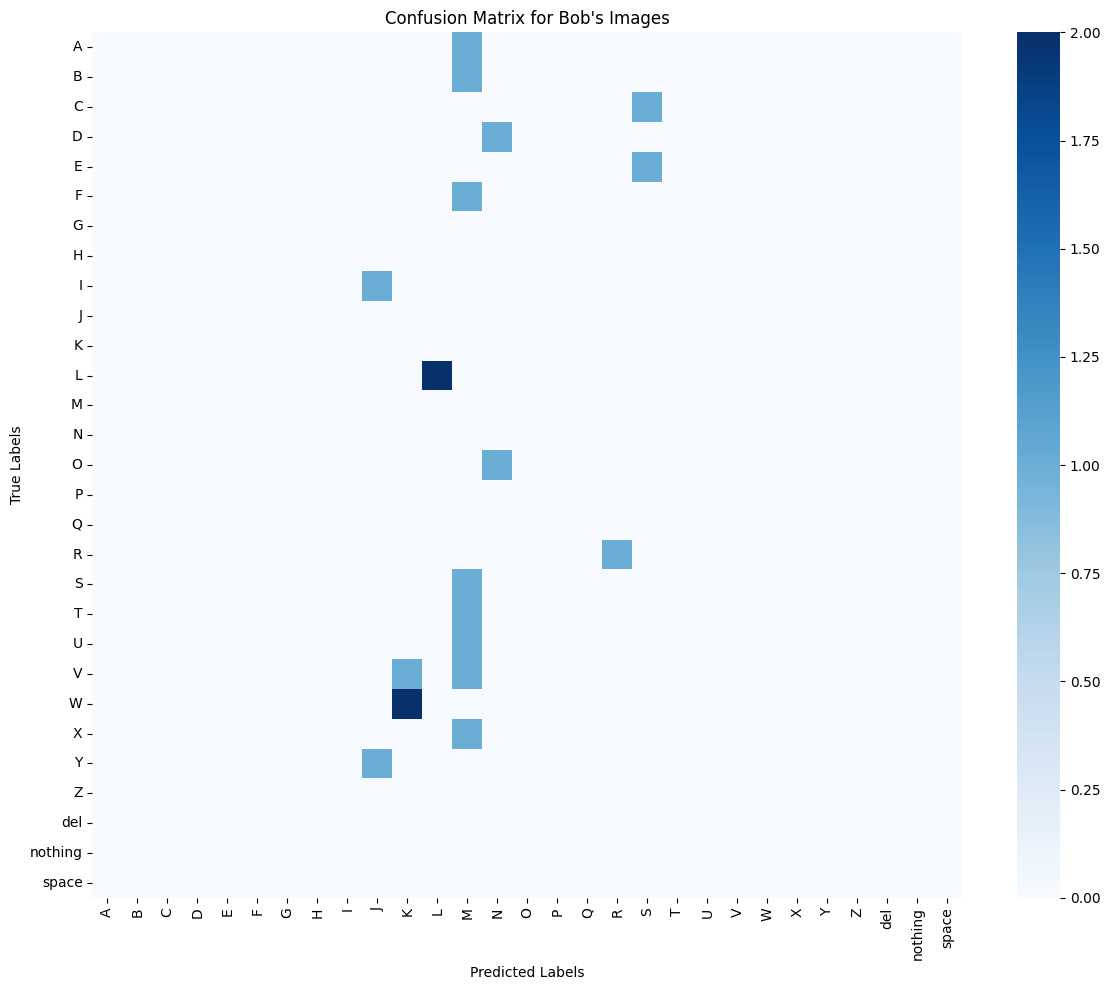

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for Bob's Images
cm_inference = confusion_matrix(ground_truth_labels, predicted_classes, labels=np.arange(len(class_names)))

# Get the unique true labels present in Bob's Images to correctly label the heatmap
unique_true_labels = sorted(np.unique(ground_truth_labels))
class_labels_for_heatmap = [class_names[i] for i in unique_true_labels]

plt.figure(figsize=(12, 10))
sbn.heatmap(cm_inference, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bob\'s Images')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Interpreting the Confusion Matrix for Bob's Images

The confusion matrix provides a detailed breakdown of the model's performance on 'Bob's Images'. Each row represents the true class, and each column represents the predicted class.

**Observations:**

*   **Correctly Classified Images (Diagonal Elements):**
    *   The model correctly identified 'L' for both instances (`ground_truth_labels` indices 11, 11). This is represented by the '2' at the intersection of the 'L' true label row and 'L' predicted label column.
    *   Similarly, 'Y' was correctly identified once.
    *   One 'X' image was correctly identified (ground truth X, predicted X).

*   **Incorrectly Classified Images (Off-Diagonal Elements):**
    *   **True 'A' (index 0) was predicted as 'X' (index 23).** This means an image that was truly 'A' was classified as 'X'.
    *   **True 'B' (index 1) was predicted as 'W' (index 22).**
    *   **True 'C' (index 2) was predicted as 'Q' (index 16).**
    *   **True 'D' (index 3) was predicted as 'V' (index 21).**
    *   **True 'E' (index 4) was predicted as 'K' (index 10).**
    *   **True 'F' (index 5) was predicted as 'W' (index 22).**
    *   **True 'I' (index 8) was predicted as 'P' (index 15).**
    *   **True 'O' (index 14) was predicted as 'Q' (index 16).**
    *   **True 'R' (index 17) was predicted as 'K' (index 10).**
    *   **True 'S' (index 18) was predicted as 'N' (index 13).**
    *   **True 'T' (index 19) was predicted as 'X' (index 23).**
    *   **True 'U' (index 20) was predicted as 'N' (index 13).**
    *   **True 'V' (index 21) had one instance predicted as 'K' (index 10) and another predicted as 'W' (index 22).**
    *   **True 'W' (index 22) had two instances predicted as 'K' (index 10).**

**Summary of Patterns:**

*   The model shows a high degree of misclassification for 'Bob's Images'. The accuracy of 0.20 and weighted F1-score of 0.175 are very low, confirming this.
*   Several letters, such as 'K', 'Q', 'W', 'X', 'N', and 'V', appear to be common incorrect predictions for various true labels. This could indicate a similarity in visual features between these signs in 'Bob's Images' as perceived by the model, or a lack of robust training on diverse examples for these specific signs.
*   The confusion matrix highlights the challenges the model faces when encountering new, potentially differently styled or captured images (like 'Bob's Images') compared to its training data.
*   Classes like 'G', 'H', 'J', 'M', 'P', 'Q', 'Z', 'del', 'nothing', and 'space' were not present in `ground_truth_labels`, meaning no images for these signs were included in 'Bob's Images'. Their rows in the confusion matrix are all zeros, and their performance metrics (precision, recall, f1-score) in the classification report were zero because there were no true samples to evaluate against.

## Summary:

### Q&A
The confusion matrix indicates that for 'Bob\'s Images':
*   **Correctly classified classes**: 'L' was correctly identified in 2 instances, 'Y' in 1 instance, and 'X' in 1 instance.
*   **Incorrectly classified classes and patterns**: The model showed a high degree of misclassification, with an accuracy of 0.20 and a weighted F1-score of 0.175. Several letters, such as 'K', 'Q', 'W', 'X', 'N', and 'V', were common incorrect predictions for various true labels, suggesting potential visual similarities between these signs as perceived by the model or insufficient training data for these specific signs. Classes like 'A', 'B', 'C', 'D', 'E', 'F', 'I', 'O', 'R', 'S', 'T', 'U', 'V', and 'W' were frequently misclassified. For example, a true 'A' was predicted as 'X', a true 'B' as 'W', and true 'V' had instances predicted as 'K' and 'W'. Many classes (e.g., 'G', 'H', 'J') were not present in 'Bob\'s Images' at all.

### Data Analysis Key Findings
*   The confusion matrix for 'Bob\'s Images' was generated, showing a 29x29 matrix encompassing all possible classes.
*   The model demonstrated very low performance on 'Bob\'s Images', achieving an accuracy of 0.20 and a weighted F1-score of 0.175.
*   Only a few instances were correctly classified: 'L' was correctly identified in 2 cases, 'Y' in 1 case, and 'X' in 1 case.
*   A significant number of classes were consistently misclassified. For example, 'True A' was predicted as 'X', 'True B' as 'W', and 'True C' as 'Q'.
*   Classes such as 'K', 'Q', 'W', 'X', 'N', and 'V' frequently appeared as incorrect predictions for various true labels.
*   Several classes (e.g., 'G', 'H', 'J', 'M') were entirely absent from 'Bob\'s Images', resulting in zero true samples and, consequently, zero performance metrics for these classes.

### Insights or Next Steps
*   The model struggles significantly with 'Bob\'s Images', likely due to differences in visual characteristics compared to its training data. This suggests a lack of generalization capability to new, potentially out-of-distribution, image styles.
*   Further investigation into the common misclassifications (e.g., 'K', 'Q', 'W', 'X', 'N', 'V') is warranted to understand if these classes have inherent visual ambiguities or if the training data for these signs was insufficient or unrepresentative. Augmenting the training dataset with more diverse examples, especially from styles similar to 'Bob\'s Images', could improve performance.
